DOES THE PUBLIC SENTIMENT HAVE AN EFFECT ON CRYPTOCURRENCY PRICE CHANGE?

https://github.com/uic-cs418/cs418-spring22-sixth-sense/blob/main/CS418_Sixth_Sense.ipynb

INTRODUCTION

Cryptocurrency has been a fast-growing technology that has become more widely accepted. In recent years, prices for cryptocurrency have skyrocketed and much is still not known about the causes behind these price fluctuations. Due to cryptocurrency not being controlled by any authority or being backed by any real items, its main price influence is due to the public. Thus, our project wants to explore the relation between public sentiment of cryptocurrency and whether or not it affects the price of coins.

CHANGES

N/A

In [118]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates
from matplotlib.pyplot import figure
import json
import nltk
import sklearn

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import textblob
from textblob import TextBlob
import wordcloud
from wordcloud import WordCloud
plt.style.use('fivethirtyeight')


ModuleNotFoundError: No module named 'textblob'

In [119]:
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to C:\Users\Sharan
[nltk_data]     Gottuparthi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Sharan
[nltk_data]     Gottuparthi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Sharan
[nltk_data]     Gottuparthi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Sharan
[nltk_data]     Gottuparthi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

DATA CLEANING

For our data cleaning, we first started with a dataset of hundreds of cryptocurrencies and their prices tracked by date through 2013-2018. The dates were converted from UNIX time to a universal datetime. In addition, only the price and dates columns were kept. Because there are hundreds of cryptocurrencies, we filtered out only the top 5-10 most popular, which capture almost all of the most valuable cryptocurrencies. eg. Bitcoin, Ethereum, etc.

In [120]:
# Source: https://data.world/chasewillden/cryptocurrency-price-by-date-2013-february-2018
crypto_prices_df = pd.read_csv('chasewillden-cryptocurrency-price-by-date-2013-february-2018/chasewillden-cryptocurrency-price-by-date-2013-february-2018/data/cryptocurrency_prices_by_date.csv')

# Extract prices for the timeframe 01/01/2015 - 12/31/2018
# 2015-01-01 00:00:00  => 1420070400000
# 2018-12-31 23:59:59 => 1546261199000
crypto_prices_df = crypto_prices_df[(crypto_prices_df['date'] >= 1420070400000) & (crypto_prices_df['date'] <= 1546261199000)]

# Convert Unix time to Date time
crypto_prices_df['date'] = pd.to_datetime(crypto_prices_df['date'], unit='ms')
crypto_prices_df['Year'] = crypto_prices_df['date'].dt.year
crypto_prices_df['Month'] = crypto_prices_df['date'].dt.month
crypto_prices_df['Day'] = crypto_prices_df['date'].dt.day
crypto_prices_df[(crypto_prices_df['currency'] == 'bitcoin')].head(10)

,currency,date,price,Year,Month,Day
64769,bitcoin,2015-01-01 02:40:00,317.848,2015,1,1
64770,bitcoin,2015-01-02 00:53:20,313.639,2015,1,2
64771,bitcoin,2015-01-03 01:53:20,314.870,2015,1,3
64772,bitcoin,2015-01-04 00:06:40,281.246,2015,1,4
64773,bitcoin,2015-01-05 01:06:40,266.723,2015,1,5
64774,bitcoin,2015-01-06 02:06:40,274.168,2015,1,6
64775,bitcoin,2015-01-07 00:20:00,283.238,2015,1,7
64776,bitcoin,2015-01-08 01:20:00,293.754,2015,1,8
64777,bitcoin,2015-01-09 02:20:00,282.507,2015,1,9
64778,bitcoin,2015-01-10 08:53:20,277.861,2015,1,10


In [121]:
crypto_prices_df.head()

,currency,date,price,Year,Month,Day
0,0x,2017-08-16 13:26:40,0.111725,2017,8,16
1,0x,2017-08-17 14:26:40,0.211486,2017,8,17
2,0x,2017-08-18 15:26:40,0.283789,2017,8,18
3,0x,2017-08-19 16:26:40,0.511434,2017,8,19
4,0x,2017-08-20 14:40:00,0.429522,2017,8,20


In [122]:
#Source: https://edloginova.github.io/cryptodata/
news = pd.read_json('cryptodata/news.json')
reddit = pd.read_json('cryptodata/reddit.json')
bitcoinTalk = pd.read_json('cryptodata/bitcointalk.json')

In [123]:
news = news[(news['date'].dt.year >= 2015) & (news['date'].dt.year <= 2018)]
reddit = reddit[(reddit['date'].dt.year >= 2015) & (reddit['date'].dt.year <= 2018)]
bitcoinTalk = bitcoinTalk[(bitcoinTalk['date'].dt.year >= 2015) & (bitcoinTalk['date'].dt.year <= 2018)]

print(len(news))
print(len(reddit))
print(len(bitcoinTalk))

63252
2752380
1642540


In [124]:
news['Year'] = news['date'].dt.year
news['Month'] = news['date'].dt.month
reddit['Year'] = reddit['date'].dt.year
reddit['Month'] = reddit['date'].dt.month
bitcoinTalk['Year'] = bitcoinTalk['date'].dt.year
bitcoinTalk['Month'] = bitcoinTalk['date'].dt.month

news.head()

,text,post_id,date,Year,Month
9698,Venture capitalist Lou Kerner says bitcoin is ...,9783,2018-12-31 23:37:58,2018,12
9699,"Charlie Lee, the creator of Litecoin and the m...",9784,2018-12-31 23:30:27,2018,12
9700,As crypto’s value has dropped across the board...,9785,2018-12-31 23:24:38,2018,12
9701,Hacks and heists have been a threat for as lon...,9786,2018-12-31 23:05:03,2018,12
9702,It’s been over a year ...,9787,2018-12-31 22:46:45,2018,12


EDA:

This dataframe is what our data looks like after we've cleaned the data. 

In [125]:
popular_cryptos = ['bitcoin','ethereum', 'tether', 'binance-coin', 'cardano']
prices_of_popular_cryptos = crypto_prices_df[crypto_prices_df['currency'].isin(popular_cryptos)]

# This method takes year and returns plots of price per every year
def price_of_popular_cryptos_during_a_particular_year(year):
    price = prices_of_popular_cryptos[(prices_of_popular_cryptos['Year']==year)]
    ax = sns.lineplot(data=price, x='Month', y='price', hue='currency',marker='o')
    ax.set(xticks=prices_of_popular_cryptos.Month.values)
    ax.set_title('Price of Coin by Month ' + str(year))
    plt.show()
    return price


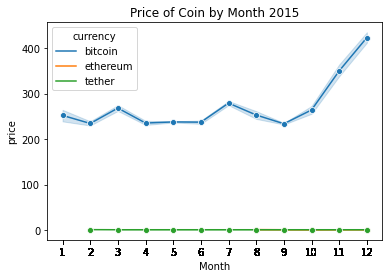

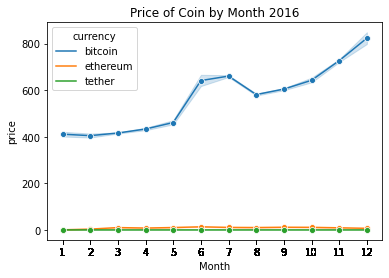

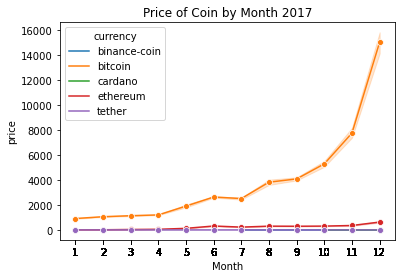

In [126]:
#plots of price per year
price_2015 = price_of_popular_cryptos_during_a_particular_year(2015)
price_2016 = price_of_popular_cryptos_during_a_particular_year(2016)
price_2017 = price_of_popular_cryptos_during_a_particular_year(2017)

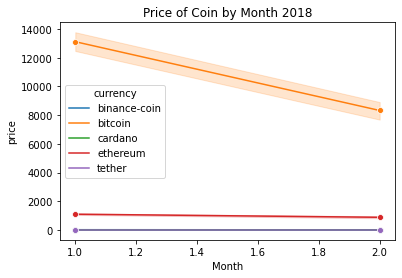

In [127]:
price_2018 = prices_of_popular_cryptos[(prices_of_popular_cryptos['Year']==2018)]
ax = sns.lineplot(data=price_2018, x='Month', y='price', hue='currency',marker='o')
ax.set_title('Price of Coin by Month 2018')
plt.show()


In [128]:
news_per_year = news.groupby(['Year']).size().to_frame('size').reset_index()
news_per_month = news.groupby(['Year','Month']).size().to_frame('size').reset_index()
reddit_per_year = reddit.groupby(['Year']).size().to_frame('size').reset_index()
reddit_per_month = reddit.groupby(['Year','Month']).size().to_frame('size').reset_index()
bitcoinTalk_per_year = bitcoinTalk.groupby(['Year']).size().to_frame('size').reset_index()
bitcoinTalk_per_month = bitcoinTalk.groupby(['Year','Month']).size().to_frame('size').reset_index()



In [129]:
news_per_year.loc[-1] = [2015,0]
news_per_year.index = news_per_year.index + 1  # shifting index
news_per_year.sort_index(inplace=True) 
print(news_per_year)

   Year   size
0  2015      0
1  2016      1
2  2017   8366
3  2018  54885


C:\Users\SHARAN~1\AppData\Local\Temp/ipykernel_34248/1552738899.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


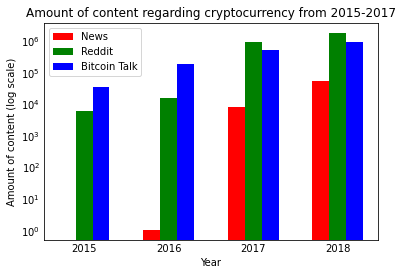

In [130]:
fig,ax = plt.subplots()
index = np.arange(max(len(reddit_per_year['Year']), len(news_per_year['Year']), len(bitcoinTalk_per_year['Year'])))
bar_width = 0.2
opacity = 0.8


ax.bar(index-bar_width, news_per_year['size'], color='r', width=bar_width, label='News')
ax.bar(index, reddit_per_year['size'], color='g', width=bar_width, label='Reddit')
ax.bar(index+bar_width, bitcoinTalk_per_year['size'], color='b', width=bar_width, label='Bitcoin Talk')

ax.set_yscale('log')
ax.tick_params(axis=u'both', which=u'both',length=0)
labels = ['','2015','','2016','','2017','','2018','']
ax.set_xticklabels(labels)

plt.xlabel('Year')
plt.ylabel('Amount of content (log scale)')
plt.title('Amount of content regarding cryptocurrency from 2015-2017')
plt.legend(loc='best')

plt.show()

EDA:

From our visualization, we see that we don't have any news data for 2015 and 2016. We believe sentiment analysis on news to be a bit more credible than Reddit and Bitcoin Talk because on those online websites, anyone can post a comment. Thus, our data is making us look more closely at 2017 and 2018 which are interesting years for cryptocurrency (meteoric spike for Bitcoin, etc.). Our hypothesis was that positive public sentiment will cause increase in cryptocurrency prices. This is important because with cryptocurrency becoming more mainstream, knowing the mechanisms behind price fluctuations will be paramount for investing, predicting the future, and more.

In [131]:
#sentiment analysis using vader
sid = SentimentIntensityAnalyzer()
news['scores'] = news['text'].apply(lambda text: sid.polarity_scores(text))
news['compound']  = news['scores'].apply(lambda score_dict: score_dict['compound'])
news['comp_score'] = news['compound'].apply(lambda c: 1 if c >=0 else -1)
news = news.drop(['scores', 'compound'], axis = 1)
news["Date_extracted"] = news["date"].dt.date
def text_extracting(data):
    data = word_tokenize(data)
    for i in range(len(data)):
        if data[i] == 'bitcoin':
            return 'bitcoin'
        elif data[i] == 'ethereum':
            return 'ethereum'
        elif data[i] == 'tether':
            return 'tether'
        elif data[i] == 'binance-coin':
            return 'binance-coin'
        elif data[i] == 'cardano':
            return 'cardano'
    return 'rest'
news['crypto'] = news['text'].apply(text_extracting)
news = news.sort_values('Date_extracted')
news['Year'] = news['date'].dt.year
news['Month'] = news['date'].dt.month
news['Day'] = news['date'].dt.day
news.head()


,text,post_id,date,Year,Month,comp_score,Date_extracted,crypto,Day
78901,SuperNET Weekly No. 13CORE and CORE Media were...,79011,2016-06-04,2016,6,1,2016-06-04,rest,4
38830,This week we have several updates about Waves ...,38915,2017-02-13,2017,2,1,2017-02-13,bitcoin,13
78900,WAVES Weekly No. 30This week we have several u...,79010,2017-02-13,2017,2,1,2017-02-13,bitcoin,13
78899,WAVES Weekly No. 31Last week has seen a number...,79009,2017-02-20,2017,2,1,2017-02-20,bitcoin,20
38829,Last week has seen a number of updates that sh...,38914,2017-02-20,2017,2,1,2017-02-20,bitcoin,20


ML:
We used sentiment analysis from Vader on the news dataset, and obtained a "comp_score" which is 1 for positive, 
-1 for negative. By averaging the sentiment over each month per year, we can then compare the prices of coins per 
year with their public sentiment.

In [132]:
popular_cryptos2 = ['bitcoin','ethereum', 'tether']
news_of_popular_cryptos2 = news[news['crypto'].isin(popular_cryptos2)]
# This method takes year and returns plots of news per every year
def sentiment_of_popular_cryptos_during_a_particular_year(year):
    news1 = news_of_popular_cryptos2[(news_of_popular_cryptos2['Year']==year)]
    ax = sns.lineplot(data=news1, x='Month', y='comp_score', hue='crypto',marker='o',ci= None)
    ax.set(xticks=news_of_popular_cryptos2.Month.values)
    plt.title('news of Coin by Month ' + str(year))
    plt.show()
    return news1

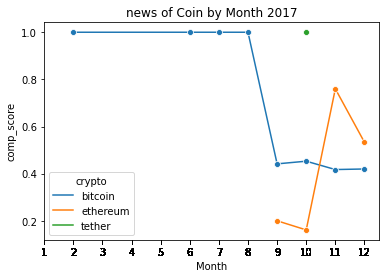

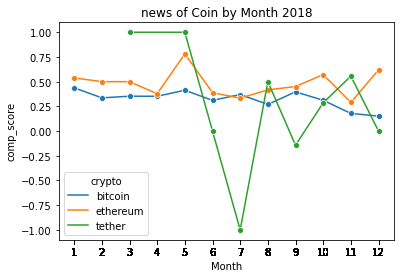

In [133]:
#plots of sentiment per year
news_2017 = sentiment_of_popular_cryptos_during_a_particular_year(2017)
news_2018 = sentiment_of_popular_cryptos_during_a_particular_year(2018)

In [134]:
popular_cryptos3 = ['binance-coin', 'cardano']
news_of_popular_cryptos3 = news[news['crypto'].isin(popular_cryptos3)]
# This method takes year and returns plots of news per every year
def sentiment_of_popular_cryptos_during_a_particular_year(year):
    news1 = news_of_popular_cryptos3[(news_of_popular_cryptos3['Year']==year)]
    return news1

In [135]:
sentiment_of_popular_cryptos_during_a_particular_year(2018)



,text,post_id,date,Year,Month,comp_score,Date_extracted,crypto,Day
61623,A $3.3 Billion Claim: Has Cardano's Blockchain...,61733,2018-07-12 04:00:31,2018,7,1,2018-07-12,cardano,12
19831,US exchange Coinbase is reportedly exploring p...,19916,2018-09-08 14:01:38,2018,9,1,2018-09-08,cardano,8
56500,"The Daily: Coinbase Explores Crypto ETF, Chang...",56610,2018-09-08 14:01:38,2018,9,1,2018-09-08,cardano,8


ML:

From our sentiment analysis done on 2017, we can see that public sentiment for Bitcoin has dropped sharply from overwhelmingly positive from August to September. However, from our price graphs, the price of bitcoin increased against our expectations.

In [136]:
#plotting price and sentiment in a single plot for bitcoin
def sentiment_price_of_popular_cryptos_during_a_particular_year(year,coin):
    popular_cryptos2 = [coin.lower()]
    news_of_popular_cryptos2 = news[news['crypto']=='bitcoin']
    news_year = news_of_popular_cryptos2[(news_of_popular_cryptos2['Year']==year)]
    prices_of_popular_cryptos = crypto_prices_df[crypto_prices_df['currency'].isin(popular_cryptos2)]
    price_year = prices_of_popular_cryptos[(prices_of_popular_cryptos['Year']==year)]
    fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True, subplot_kw=dict(frameon=False)) # frameon=False removes frames
    plt.subplots_adjust(hspace=.2)
    plt.title('Fluctuations in price and sentiment for year ' + str(year) , y= 2.2)
    ax1.grid()
    ax2.grid()
    ax1.plot(news_year['Month'], news_year['comp_score'], color='r',label ='sentiment')
    ax2.plot(price_year['Month'], price_year['price'], color='b', linestyle='--',label ='price')
    ax1.legend(bbox_to_anchor =(1.1, 0.8))
    ax2.legend(bbox_to_anchor =(1.32, 1.6))
    plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    plt.xlabel('Months')
    ax1.set_ylabel('Sentiment')
    ax2.set_ylabel('Price')
    plt.show()
    

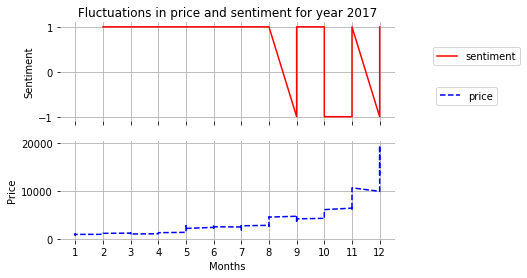

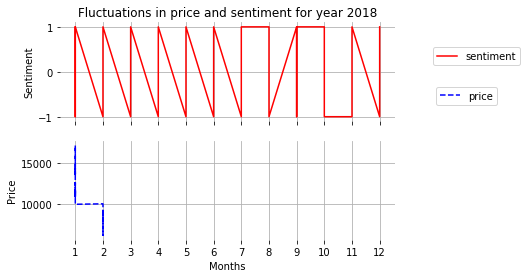

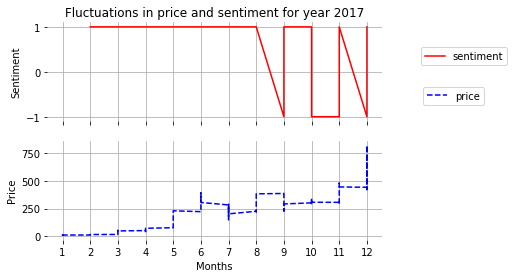

In [137]:
price_sentiment_2017 = sentiment_price_of_popular_cryptos_during_a_particular_year(2017, 'Bitcoin')
price_sentiment_2017 = sentiment_price_of_popular_cryptos_during_a_particular_year(2018, 'Bitcoin')
price_sentiment_2017 = sentiment_price_of_popular_cryptos_during_a_particular_year(2017, 'Ethereum')

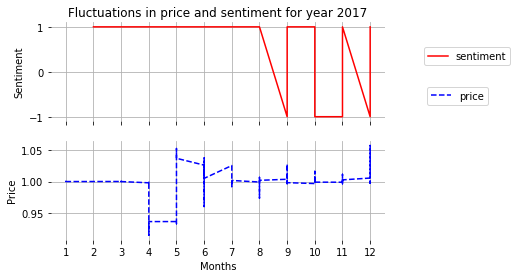

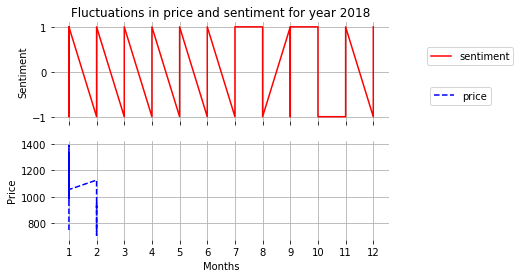

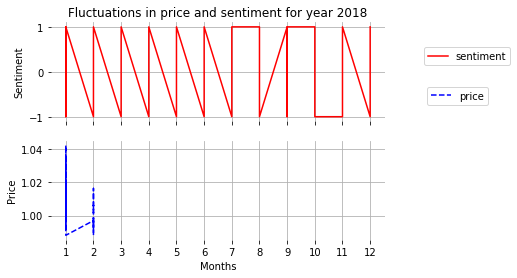

In [138]:
price_sentiment_2017 = sentiment_price_of_popular_cryptos_during_a_particular_year(2017, 'Tether')
price_sentiment_2017 = sentiment_price_of_popular_cryptos_during_a_particular_year(2018, 'Ethereum')
price_sentiment_2017 = sentiment_price_of_popular_cryptos_during_a_particular_year(2018, 'Tether')

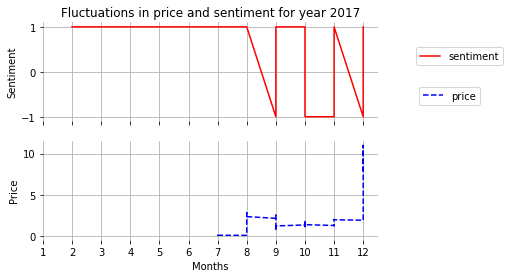

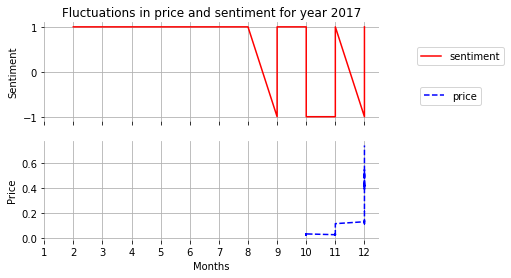

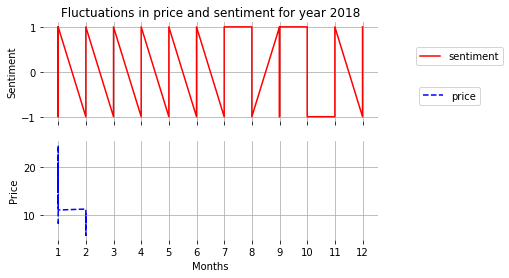

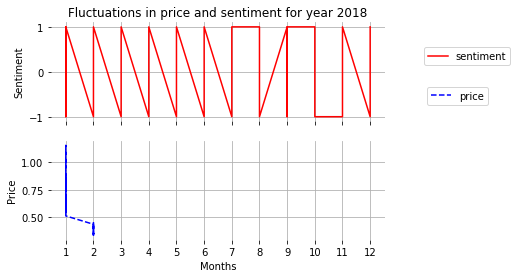

In [139]:
price_sentiment_2017 = sentiment_price_of_popular_cryptos_during_a_particular_year(2017, 'binance-coin')
price_sentiment_2017 = sentiment_price_of_popular_cryptos_during_a_particular_year(2017, 'cardano')
price_sentiment_2017 = sentiment_price_of_popular_cryptos_during_a_particular_year(2018, 'binance-coin')
price_sentiment_2017 = sentiment_price_of_popular_cryptos_during_a_particular_year(2018, 'cardano')

In [140]:
#label creation depending on price variation
crypto_prices_df["Date_extracted"] = crypto_prices_df["date"].dt.date
crypto_prices_df = crypto_prices_df.sort_values('Date_extracted')
crypto_prices_df['price_variation'] = crypto_prices_df['price'].diff()
crypto_prices_df['price_raise/drop'] = np.where(crypto_prices_df['price_variation']>0, 1, -1)
crypto_prices_df = crypto_prices_df.groupby(['Date_extracted'])['price_raise/drop'].sum().reset_index()
crypto_prices_df['price_raise/drop'] = np.where(crypto_prices_df['price_raise/drop']>0,1,-1)
crypto_prices_df

,Date_extracted,price_raise/drop
0,2015-01-01,1
1,2015-01-02,-1
2,2015-01-03,1
3,2015-01-04,1
4,2015-01-05,1
...,...,...
1132,2018-02-06,-1
1133,2018-02-07,1
1134,2018-02-08,-1
1135,2018-02-09,-1


ML:

From the public sentiment, we can then add a label of whether or not the cryptocurrency price increased (+1) or decreased (-1) the next day. This will be our truth values for our machine learning model as our goal is to predict whether or not the price will increased based on public sentiment. We take a further at Bitcoin, which is by far the most valuable and most well-known coin. The ML model can be extended to the other coins fairly easily. 

In [141]:
#Bitcoin 
news_bitcoin = news[news['crypto']=='bitcoin']
news_bitcoin = news_bitcoin.groupby(['Date_extracted'])['comp_score'].sum().reset_index()
news_bitcoin['comp_score'] = np.where(news_bitcoin['comp_score']>0,1,-1)
news_bitcoin

,Date_extracted,comp_score
0,2017-02-13,1
1,2017-02-20,1
2,2017-06-15,1
3,2017-07-26,1
4,2017-08-15,1
...,...,...
469,2018-12-27,-1
470,2018-12-28,-1
471,2018-12-29,1
472,2018-12-30,1


In [142]:
#combining price and sentiment for bitcoin
bitcoin_price_sentiment = news_bitcoin.merge(crypto_prices_df, on = 'Date_extracted',how = 'inner')
bitcoin_price_sentiment

,Date_extracted,comp_score,price_raise/drop
0,2017-02-13,1,-1
1,2017-02-20,1,1
2,2017-06-15,1,1
3,2017-07-26,1,-1
4,2017-08-15,1,1
...,...,...,...
145,2018-02-06,1,-1
146,2018-02-07,1,1
147,2018-02-08,1,-1
148,2018-02-09,1,-1


In [143]:
#train and test split
x_train, x_test, y_train, y_test= train_test_split(bitcoin_price_sentiment['comp_score'], bitcoin_price_sentiment['price_raise/drop'])

In [144]:
# train and validation split
x_train, x_val, y_train, y_val  = train_test_split(x_train, y_train, test_size=0.25, random_state=1)

In [145]:
#baseline ML model 
class Bitcoin_label_baseline():
    def _init_(self):
        self.mode_value = 0 
    def fit(self, X, y):
        index = (crypto_prices_df['price_raise/drop']).max()
        self.mode_value = index
    def predict(self, X):
        length = X.size
        y_predict = np.empty(length,dtype=int)
        for i in range(length):
            y_predict[i] = self.mode_value
        return y_predict
baselineClf = Bitcoin_label_baseline()
baselineClf.fit(x_train,y_train)
y_predict = baselineClf.predict(x_train)
sklearn.metrics.accuracy_score(y_train,y_predict)

0.5119047619047619

In [146]:
#converting data in a format compatible with svm
def data_svmReliable_conversion(z):
    z= z.values
    return z.reshape(-1, 1)


In [147]:
# learning the classifier
def learn_classifier(X_train, y_train, kernel):
    classifier = sklearn.svm.SVC(kernel = kernel)
    return classifier.fit(X_train,y_train)

In [148]:
#evaluate the classifier
def evaluate_classifier(classifier, X_validation, y_validation):
    return sklearn.metrics.accuracy_score(y_validation , classifier.predict(X_validation))

In [149]:
#calling classifier
classifier = learn_classifier(data_svmReliable_conversion(x_train), data_svmReliable_conversion(y_train), 'linear')

C:\Users\Sharan Gottuparthi\anaconda3\envs\cs418env\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [150]:
#calculating accuracy of learned classifier with validation data
accuracy = evaluate_classifier(classifier, data_svmReliable_conversion(x_val), data_svmReliable_conversion(y_val))
accuracy

0.5

In [151]:
kf = sklearn.model_selection.KFold(n_splits=4, random_state=1, shuffle=True)
kf

KFold(n_splits=4, random_state=1, shuffle=True)

In [152]:
#finding the best kernel for svm
def best_model_selection(kf, X, y):
    scores = []
    dict = {}
    for kernel in ['linear', 'rbf', 'poly', 'sigmoid']:
        for train_index, test_index in kf.split(X):
            X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
            classifier = learn_classifier(X_train,y_train,kernel)
            scores.append(evaluate_classifier(classifier, X_test, y_test))
        dict[kernel] = np.mean(scores)
        scores = []
    return max(dict , key = dict.get)
best_kernel = best_model_selection(kf, data_svmReliable_conversion(x_train), data_svmReliable_conversion(y_train))

C:\Users\Sharan Gottuparthi\anaconda3\envs\cs418env\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Sharan Gottuparthi\anaconda3\envs\cs418env\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Sharan Gottuparthi\anaconda3\envs\cs418env\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Sharan Gottuparthi\anaconda3\envs\cs418env\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning

In [153]:
#prediction on test data
def classify(classifier, x_test):
    return classifier.predict(x_test)

In [154]:
#predicting 
classifier = learn_classifier(data_svmReliable_conversion(x_train), data_svmReliable_conversion(y_train), best_kernel)
y_pred = classify(classifier, data_svmReliable_conversion(x_test))
y_pred

C:\Users\Sharan Gottuparthi\anaconda3\envs\cs418env\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([-1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1])

In [155]:
y_train.shape

(84,)

In [156]:
# Prediction using Gaussian Naive Bayes
gnb = GaussianNB()

#Train the model using the training sets
classifier = gnb.fit(data_svmReliable_conversion(x_train), data_svmReliable_conversion(y_train))

#Predict the response for test dataset

accuracy = evaluate_classifier(classifier, data_svmReliable_conversion(x_val), data_svmReliable_conversion(y_val))
print('accuracy' , accuracy)

classify(classifier, data_svmReliable_conversion(x_test))

accuracy 0.5


C:\Users\Sharan Gottuparthi\anaconda3\envs\cs418env\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([-1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1])

In [157]:
# prediction using Decision trees
clf = DecisionTreeClassifier()

#Train the model using the training sets
classifier = clf.fit(data_svmReliable_conversion(x_train), data_svmReliable_conversion(y_train))

#Predict the response for test dataset

accuracy = evaluate_classifier(classifier, data_svmReliable_conversion(x_val), data_svmReliable_conversion(y_val))
print('accuracy' , accuracy)

classify(classifier, data_svmReliable_conversion(x_test))

accuracy 0.5


array([-1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1])

In [158]:
#prediction using KNN
knn = KNeighborsClassifier()

#Train the model using the training sets
classifier = knn.fit(data_svmReliable_conversion(x_train), data_svmReliable_conversion(y_train))

#Predict the response for test dataset

accuracy = evaluate_classifier(classifier, data_svmReliable_conversion(x_val), data_svmReliable_conversion(y_val))
print('accuracy' , accuracy)

classify(classifier, data_svmReliable_conversion(x_test))

accuracy 0.4642857142857143


C:\Users\Sharan Gottuparthi\anaconda3\envs\cs418env\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [159]:
#prediction using logistic regression
clf = LogisticRegression(random_state=0)

#Train the model using the training sets
classifier = clf.fit(data_svmReliable_conversion(x_train), data_svmReliable_conversion(y_train))

#Predict the response for test dataset

accuracy = evaluate_classifier(classifier, data_svmReliable_conversion(x_val), data_svmReliable_conversion(y_val))
print('accuracy' , accuracy)

classify(classifier, data_svmReliable_conversion(x_test))

accuracy 0.5


C:\Users\Sharan Gottuparthi\anaconda3\envs\cs418env\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([-1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1])

Different Approach To Calculate Sentiments and Find Relation Between Sentiments and Price

Selecting All Currencies Table and Converting Columns to Float type and Sorting it according to Market Cap in Descending Order to find Currency with highest Market Cap.

In [160]:
currency = pd.read_csv("chasewillden-cryptocurrency-price-by-date-2013-february-2018/All Currencies Table.csv")
#currency.head
currency = currency.dropna()

#Market Cap is total values of coins mined.
#Circulating Supply is total coins actively available for trading
#Volume is how many times a coin changes its hand in given time frame.

currency['Market Cap'] = currency['Market Cap'].astype(float)
currency['Price'] = currency['Price'].astype(float)
currency['Circulating Supply'] = currency['Circulating Supply'].astype(float)
currency['Volume (24hr)'] = currency['Volume (24hr)'].astype(float)

currency = currency.sort_values(by=['Market Cap'], ascending=False)
currency.head(5)

,Number,Name,Symbol,Market Cap,Price,Circulating Supply,Volume (24hr),1h,24h,7d
0,1,Bitcoin,BTC,1.507030e+11,8940.740000,1.685576e+07,8.103300e+09,-0.63,11.22,3.58
1,2,Ethereum,ETH,8.754697e+10,897.729000,9.752049e+07,3.062570e+09,-0.41,11.99,-0.25
2,3,Ripple,XRP,4.062771e+10,1.041490,3.900922e+10,2.504810e+09,-0.37,32.86,23.94
3,4,Bitcoin Cash,BCH,2.294639e+10,1353.040000,1.695914e+07,1.149550e+09,0.11,7.89,18.32
4,5,Cardano,ADA,1.163729e+10,0.448847,2.592707e+10,7.603720e+08,-0.71,27.62,23.61


Taking News dataset and Selecting Bitcoin Mentions Since Bitcoin has Largest Market Cap.

In [161]:
btc = pd.read_json("cryptodata/news.json")

#First Data Set
btc = btc[btc["text"].str.contains("Bitcoin | BTC") == True]
btc['Month'] = btc['date'].dt.month
btc

,text,post_id,date,Month
0,"The crypto rally has lots more runway ahead, e...",85,2019-04-06 23:30:38,4
1,The crypto markets have continued to surge tod...,86,2019-04-06 22:30:24,4
2,BTC Closing Above Its 200-Day MA Signals Bull ...,87,2019-04-06 22:23:25,4
3,"Bitcoin&#8217;s [BTC] surge over $5,000 gave m...",88,2019-04-06 22:03:21,4
4,Litecoin has continued cryptocurrency’s price ...,89,2019-04-06 21:59:57,4
...,...,...,...,...
78895,Top Bitcoin Exchanges : Places to start invest...,79005,2017-06-15 22:28:11,6
78898,BitcoinThe post Bitcoin appeared first on Cryp...,79008,2017-06-15 19:26:43,6
78899,WAVES Weekly No. 31Last week has seen a number...,79009,2017-02-20 00:00:00,2
78900,WAVES Weekly No. 30This week we have several u...,79010,2017-02-13 00:00:00,2


DATA CLEANING

In [162]:
#Clean the text
def cleanTxt(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #Removes @mentions
    text = re.sub(r'#', '', text) #Removes the hashtags
    text = re.sub(r'RT[\s]+','',text) #Removes RT 
    text = re.sub(r'https?:\/\/\S+','', text) #Removes hyperlinks

    return text

#clean text
#btc

#Function to get subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#Function to get Polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity


#Function to label the negative, neutral and positive analytics
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

#def plotSentiment(btc):

In [163]:
# All Functions 
def All_Functions(btc):
    
    #Cleaning the text
    btc['text'] = btc['text'].apply(cleanTxt)
    # Create Subjectivity and Polarity Columns
    btc['Subjectivity'] = btc['text'].apply(getSubjectivity)
    btc['Polarity'] = btc['text'].apply(getPolarity)
    btc['Analysis'] = btc['Polarity'].apply(getAnalysis)
    #plotSentiment(btc)
    return btc
    
btc = All_Functions(btc)
#btc

NameError: name 'TextBlob' is not defined

Plotting Sentiment Vs Polarity

In [ ]:
# Plot the polarity and subjectivity
plt.figure(figsize=(12,8))
#for i in range(0, btc.shape[0]):
#plt.scatter(btc['Polarity'][i], btc['Subjectivity'][i], color='Blue')

plt.scatter(btc['Polarity'], btc['Subjectivity'], color='Blue')

plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

#Percentage of positive tweets
ptweets = btc[btc.Analysis == 'Positive']
ptweets = ptweets['text']
        
ptext = round( (ptweets.shape[0] / btc.shape[0])*100, 1)
#print(ptext)
    
#Percentage of negative tweets
ntweets = btc[btc.Analysis == 'Negative']
ntweets = ntweets['text']

ntext = round((ntweets.shape[0] / btc.shape[0])*100, 1)
#print(ntext)
   
#plotSentiment(btc)

In [ ]:
# Show the value counts
btc['Analysis'].value_counts()

# Plot and visualize the counts 
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
btc['Analysis'].value_counts().plot(kind='bar')
plt.show()

In [ ]:
## For Only 2017

start_date = '01-01-2017'
end_date = '31-12-2017'
btc_17 = (btc['date'] > start_date) & (btc['date'] <= end_date)
btc_2017 = btc.loc[btc_17]
btc_2017

In [ ]:
btc_2017['Analysis'].value_counts()
# Count of Positive, Negative and Neutral Tweets
print("Sentiment Count", btc_2017['Analysis'].value_counts())
# Plot and visualize the counts 
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
btc_2017['Analysis'].value_counts().plot(kind='bar')
plt.show() 

In [ ]:
Pbtc = btc_2017['Analysis'].value_counts().Positive
Nbtc = btc_2017['Analysis'].value_counts().Negative

Pbtc

In [ ]:
#btc_2017['Month'] = btc['date'].dt.month
btc_2017
#btc_20177 = btc_2017.groupby(['Month'])['Analysis'].count()
df2 = btc_2017.groupby(['Month','Analysis']).size().reset_index(name='counts')
print(df2)

In [ ]:
dPosit = df2.loc[df2['Analysis'] == 'Positive']
dNegat = df2.loc[df2['Analysis'] == 'Negative']
#Pbtc = df2['Analysis'].value_counts().Positive
#Pbtc
dPosit

In [ ]:
type("dPosit['counts'][0]")

In [ ]:
#dPosit["counts"]=dPosit.iloc[dPosit["counts"].values.astype(int)]
#type("df2['counts'][0]")

#dNegat["counts"] = dNegat["counts"].apply(lambda x: [int(el) for el in x.strip("[]").split(",")])

#type("dNegat['counts'][0]")

In [ ]:
#Nbtc = df2['Analysis'][1].value_counts().Negative

In [ ]:
""""
finalSenti = [0] * 13
#def totalCounting():
for i in range(13):        
    i += 1
    for j in range(13):
        j += 1
        if dPosit['Month'][j] == i:
            Pbtc = btc_2017['Analysis'].value_counts().Positive
            finalSenti[i] += dPosit[counts][j]
        if dNegat['Month'][j] == i:
            Nbtc = btc_2017['Analysis'].value_counts().Negative
            finalSenti[i] = finalSenti[i] - dNegat[counts][j]   
#df2['Total'] = finalSenti
"""

In [ ]:
#x = df2['Month'][1]
#x


In [ ]:
#For 2017
#df2.plot(x='Month', y = 'counts')
from matplotlib import rcParams

sns.lineplot(data = df2, x = "Month" , y = "counts" , hue = "Analysis").set(title = 'Sentiment Count for 2017 on News Data', ylabel = 'Count of Sentiment of Tweets')
rcParams['axes.titlepad'] = 5
plt.legend(labels=["Positive","Negative", "Neutral"], loc = 2, bbox_to_anchor = (1,1))

In [ ]:
## For Only 2018

start_date = '01-01-2018'
end_date = '01-01-2019'
btc_18 = (btc['date'] > start_date) & (btc['date'] <= end_date)
btc_2018 = btc.loc[btc_18]
btc_2018

In [ ]:
btc_2018['Analysis'].value_counts()
# Count of Positive, Negative and Neutral Tweets
print("Sentiment Count", btc_2017['Analysis'].value_counts())
# Plot and visualize the counts 
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
btc_2018['Analysis'].value_counts().plot(kind='bar')
plt.show() 

In [ ]:
#btc_2017['Month'] = btc['date'].dt.month
btc_2018
#btc_20177 = btc_2017.groupby(['Month'])['Analysis'].count()
df18 = btc_2018.groupby(['Month','Analysis']).size().reset_index(name='counts')
print(df18)

In [ ]:
#For 18
sns.lineplot(data = df18, x = "Month" , y = "counts" , hue = "Analysis").set(title = 'Sentiment Count for 2018 on News Data', ylabel = 'Count of Sentiment of Tweets')
rcParams['axes.titlepad'] = 10
plt.legend(labels=["Positive","Negative", "Neutral"], loc = 2, bbox_to_anchor = (1,1))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier(n_neighbors=3)   #,algorithm="kd_tree",n_jobs=-1

knn.fit(data_svmReliable_conversion(x_train), data_svmReliable_conversion(y_train))
kn_predicted=knn.predict(data_svmReliable_conversion(x_test))
#knn.fit(data_svmReliable_conversion(x_train), data_svmReliable_conversion(y_train))
#kn_predicted=knn.predict(data_svmReliable_conversion(x_test))

print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_test, kn_predicted)))

Our ML model with our current data has a final accuracy of 45.5%. This could be an indiction of many things such as our hypothesis being wrong, not having enough data, or training on the wrong metrics. We are looking more into this.

REFLECTION:

One of the hardest parts about the project has been wrangling the massive amounts of data into something usable. 

Our initial insight was that positive public sentiment would increased cryptocurrency price, but from our EDA we can see that this is not always the case. In fact, sometimes the price is the inverse of the public sentiment. 

Going forward, our biggest problem will be to train and tweak the machine learning model. If positive public sentiment is not directly correlated to price, then our machine learning model will have to train and capture the patterns that we humans can not see.

We think we are on track with the project.

Our belief is that it is worth proceeding with our project. Just because our initial insights were wrong, does not mean that it is not an interesting hypothesis to test.

NEXT STEPS:

Our next steps are to work more on the machine learning model and hopefully achieve a higher accuracy of predicting the price of cryptocurrency based on public sentiment. Our goal is to achieve 50%+ which means that it is better than randomly guessing whether or not the price will go up. If we require any additional EDA while working on the machine learning model, we will evaluate at the time and get it done.